In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../resources/hawaii.sqlite", echo=False)

In [6]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"])

id
station
name
latitude
longitude
elevation


In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
hawaii_measurement = Base.classes.measurement
hawaii_station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
session.query(hawaii_measurement.date).order_by(hawaii_measurement.date.desc()).first()

('2017-08-23')

In [13]:
percip = []

In [14]:
####Design a query to retrieve the last 12 months of precipitation data and plot the results. 
####Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# print(year_ago)
# Perform a query to retrieve the data and precipitation scores

percipitation = session.query(hawaii_measurement.date, hawaii_measurement.prcp).\
    filter(hawaii_measurement.date >= year_ago).\
    order_by(hawaii_measurement.date).all()








In [15]:
percipitation_df = pd.DataFrame(percipitation)
percipitation_df['Year'] = pd.DatetimeIndex(percipitation_df['date']).year
percipitation_df['Month'] = pd.DatetimeIndex(percipitation_df['date']).month

percipitation_df

,date,prcp,Year,Month
0,2016-08-23,0.00,2016,8
1,2016-08-23,0.15,2016,8
2,2016-08-23,0.05,2016,8
3,2016-08-23,NaN,2016,8
4,2016-08-23,0.02,2016,8
...,...,...,...,...
2225,2017-08-22,0.50,2017,8
2226,2017-08-23,0.00,2017,8
2227,2017-08-23,0.00,2017,8
2228,2017-08-23,0.08,2017,8


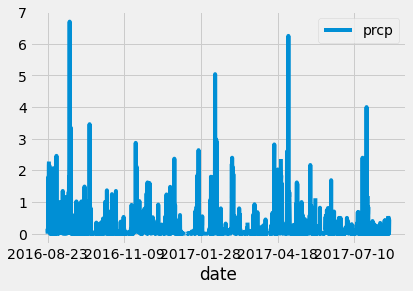

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data

percipitation_df.plot(x="date", y="prcp")

In [20]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
percip_df_updated = percipitation_df.set_index("date")
percip_df_updated_date = percip_df_updated.sort_index()
percip_df_updated_date 


,prcp,Year,Month
date,,,
2016-08-23,0.00,2016,8
2016-08-23,0.15,2016,8
2016-08-23,0.05,2016,8
2016-08-23,NaN,2016,8
2016-08-23,0.02,2016,8
...,...,...,...
2017-08-22,0.50,2017,8
2017-08-23,0.00,2017,8
2017-08-23,0.00,2017,8


In [154]:
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')

In [160]:
percipitation_plot = percip_df_updated_date.groupby(['Year', 'Month']).count()
print(percipitation_plot)

            prcp
Year Month      
2016 8        53
     9       173
     10      179
     11      171
     12      178
2017 1       170
     2       162
     3       169
     4       171
     5       167
     6       171
     7       176
     8        81


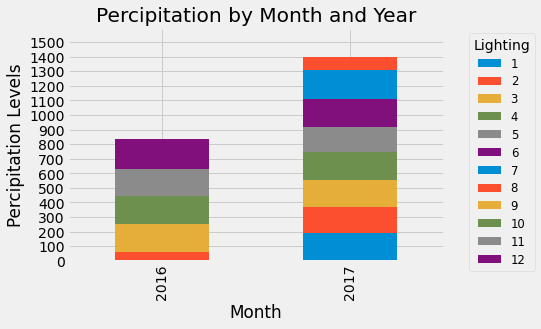

In [155]:
percipitation_plot = percip_df_updated_date.groupby(['Year', 'Month']).size().unstack().plot(kind='bar', stacked=True)
plt.title("Percipitation by Month and Year")
plt.ylabel("Percipitation Levels")
plt.xlabel("Month")
plt.ylim((0,1600))
plt.yticks(np.arange(0, 1600, 100))
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', prop=fontP, title="Lighting")
# plt.savefig("output_data/crash_lighting.png", bbox_inches = 'tight', pad_inches=0.5)
plt.show()


In [173]:
# Use Pandas to calcualte the summary statistics for the precipitation data

percipitation_summary_stats = percip_df_updated_date.describe()
percipitation_summary_stats

,prcp,Year,Month
count,2021.000000,2230.000000,2230.000000
mean,0.177279,2016.626457,6.539013
std,0.461190,0.483853,3.487857
min,0.000000,2016.000000,1.000000
25%,0.000000,2016.000000,4.000000
50%,0.020000,2017.000000,7.000000
75%,0.130000,2017.000000,10.000000
max,6.700000,2017.000000,12.000000


# Exploratory Station Analysis

In [120]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(func.count(hawaii_station.station)).all()
print(f" There are {station_count} number of stations")

 There are [(9,)] number of stations


In [123]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
common_station = session.query(func.count(hawaii_measurement.station), hawaii_measurement.station).\
    group_by(hawaii_measurement.station).\
    order_by(func.count(hawaii_measurement.station).desc()).all()

common_station

[(2772, 'USC00519281'),
 (2724, 'USC00519397'),
 (2709, 'USC00513117'),
 (2669, 'USC00519523'),
 (2612, 'USC00516128'),
 (2202, 'USC00514830'),
 (1979, 'USC00511918'),
 (1372, 'USC00517948'),
 (511, 'USC00518838')]

In [63]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperatue
from scipy import stats
from numpy import mean

station_temp = session.query(hawaii_measurement.tobs).\
    filter(hawaii_measurement.station == 'USC00519281').all()

average = mean(min_station_temp)
minimum = min(min_station_temp)
maximum = max(min_station_temp)

print(f"The averge temp is {average}")
print(f"The minimum temp is {minimum}")
print(f"The maximum temp is {maximum}")

The averge temp is 71.66378066378067
The minimum temp is (54.0,)
The maximum temp is (85.0,)


In [74]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

session.query(hawaii_measurement.date).order_by(hawaii_measurement.date.desc()).\
    filter(hawaii_measurement.station == 'USC00519281').first()
    


('2017-08-18')

In [83]:
station_temp_year_ago = dt.date(2017, 8, 18) - dt.timedelta(days=365)

station_temp = session.query(hawaii_measurement.date, hawaii_measurement.tobs).\
    filter(hawaii_measurement.station == 'USC00519281').\
    filter(hawaii_measurement.date >= station_temp_year_ago).\
    order_by(hawaii_measurement.date).all()
station_temp_df = pd.DataFrame(station_temp)
station_temp_df.head()


,date,tobs
0,2016-08-18,80.0
1,2016-08-19,79.0
2,2016-08-20,81.0
3,2016-08-21,79.0
4,2016-08-22,78.0


Text(0.5, 0, 'Temperature')

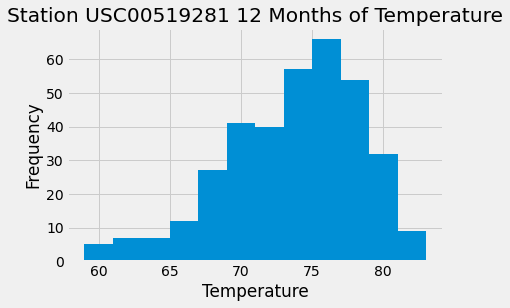

In [84]:
station_temp_df.hist(bins=12)
plt.title("Station USC00519281 12 Months of Temperature")
plt.ylabel("Frequency")
plt.xlabel("Temperature")


# Close session

In [86]:
# Close Session
session.close()